In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbn

sbn.set(font_scale=1.5)
sbn.set_style('white')

%matplotlib inline

In [2]:
data = pd.read_excel('../papers/Sullivan-2017-NatBiotech/SupTable1.xlsx').replace({'gp41': 'Env'})

In [3]:
data.head()

,Citation,Name,Start,Stop,gRNA,Percent cleaved,Entropy (bits),Number of Sequences Evaluated,Region,MIT Score
0,26607397,LTR-1,28,47,GACAAGATATCCTTGATCTG.NGG,63.471503,3.746268,386,LTR,69.0
1,26607397,LTR-2,78,97,GATTGACAGAACTACACACC.NGG,0.000000,2.660178,493,LTR,81.0
2,26607397,LTR-3,108,127,GTCAGATATCCACTGACCTT.NGG,54.931336,5.273464,801,LTR,65.0
3,26607397,LTR-4,343,362,GCTACAAGGGACTTTCCGCT.NGG,84.306293,2.959877,1319,LTR,NaN
4,26607397,LTR-5,379,398,GGCGTGGCCTGGGCGGGACT.NGG,67.902150,4.190446,1349,LTR,NaN


In [4]:
res = pd.read_excel('../data/LTR-2.freqs.xlsx')

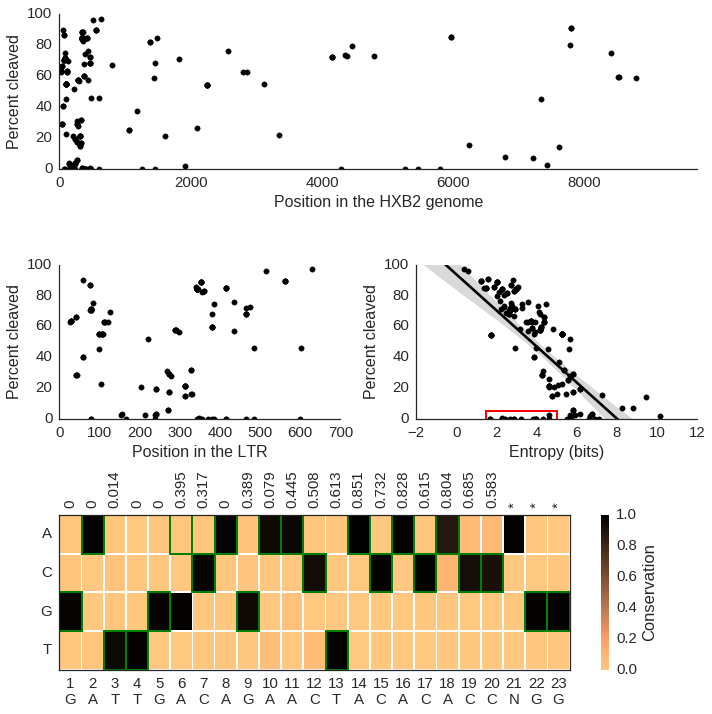

In [5]:

hxb2_ax = plt.subplot2grid((3,2), (0,0), colspan=2)

data.plot(ax=hxb2_ax, x = 'Start', y = 'Percent cleaved', 
          kind='scatter', color = 'k', s = 30)

hxb2_ax.set_xlim(0, 9717)
hxb2_ax.set_xlabel('Position in the HXB2 genome', fontsize=16)
hxb2_ax.set_ylim(0, 100)
hxb2_ax.set_ylabel('Percent cleaved', fontsize=16)
sbn.despine(ax=hxb2_ax)

ltr_ax = plt.subplot2grid((3,2), (1,0))
data.plot(ax=ltr_ax, x = 'Start', y = 'Percent cleaved', 
          kind='scatter', color = 'k', s = 30)
ltr_ax.set_xlim(0, 700)
ltr_ax.set_ylim(0, 100)
ltr_ax.set_xlabel('Position in the LTR', fontsize=16)
ltr_ax.set_ylabel('Percent cleaved', fontsize=16)
sbn.despine(ax=ltr_ax)

ent_ax = plt.subplot2grid((3,2), (1,1))

data.plot(ax=ent_ax, x = 'Entropy (bits)', y = 'Percent cleaved', 
          kind='scatter', color = 'k', s = 30)
sbn.regplot(data = data, x = 'Entropy (bits)', 
            y = 'Percent cleaved', 
            ax=ent_ax, color = 'k')

ent_ax.set_xlabel('Entropy (bits)', fontsize=16)
ent_ax.set_ylabel('Percent cleaved', fontsize=16)
ent_ax.set_ylim(0, 100)
ent_ax.bar(left = 1.5, width = 3.5,
           bottom = -1, height = 6, linewidth = 2,
           edgecolor='r', facecolor='None')

sbn.despine(ax=ent_ax)

heat_ax = plt.subplot2grid((3,2), (2,0), colspan=2)
sbn.heatmap(res, ax=heat_ax, 
            vmin = 0, vmax = 1.0,
            cbar_kws={'label': 'Conservation'}, cmap='copper_r', linewidth=0.75)
gRNA = 'GATTGACAGAACTACACACCNGG'
heat_ax.set_xticklabels(['%i\n%s' % (p, l) for p, l in enumerate(gRNA, 1)], rotation=0)

for n, l in enumerate(gRNA):
    
    bottom = (a for a, b in enumerate('TGCA.N') if b == l).next()
    
    heat_ax.bar(left = n,
           width = 1,
           height = 1,
           bottom = bottom,
           linewidth = 2,
           edgecolor = 'g', 
           facecolor='None')
[t.set_rotation(0) for t in heat_ax.get_yticklabels()]
    
    
pen_ax = heat_ax.twiny()
pen_ax.set_xlim(0, 23)
pen_ax.set_xticks(np.arange(23)+0.5)
penalties = [0, 0, 0.014, 0, 0, 0.395, 0.317, 0,
                 0.389, 0.079, 0.445, 0.508, 0.613,
                 0.851, 0.732, 0.828, 0.615, 0.804,
                 0.685, 0.583]
pen_ax.set_xticklabels(penalties+list('***'), rotation = 90)

fig = plt.gcf()
fig.set_figheight(10)
fig.set_figwidth(10)
fig.tight_layout()
fig.savefig('../papers/Sullivan-2017-NatBiotech/Fig1ABCD.png', dpi=300)

In [6]:
data.head()

,Citation,Name,Start,Stop,gRNA,Percent cleaved,Entropy (bits),Number of Sequences Evaluated,Region,MIT Score
0,26607397,LTR-1,28,47,GACAAGATATCCTTGATCTG.NGG,63.471503,3.746268,386,LTR,69.0
1,26607397,LTR-2,78,97,GATTGACAGAACTACACACC.NGG,0.000000,2.660178,493,LTR,81.0
2,26607397,LTR-3,108,127,GTCAGATATCCACTGACCTT.NGG,54.931336,5.273464,801,LTR,65.0
3,26607397,LTR-4,343,362,GCTACAAGGGACTTTCCGCT.NGG,84.306293,2.959877,1319,LTR,NaN
4,26607397,LTR-5,379,398,GGCGTGGCCTGGGCGGGACT.NGG,67.902150,4.190446,1349,LTR,NaN


In [11]:
data['Broad Spectrum'] = data['Percent cleaved'] >= 50
rdict = {'Gag': 'Gag/Pol', 'Pol': 'Gag/Pol'}
sum_table = data.replace(rdict).groupby('Region').agg({'gRNA': 'count', 'Broad Spectrum':'sum'}).astype(int)
sum_table

,gRNA,Broad Spectrum
Region,,
Env,11,5
Gag/Pol,32,22
LTR,123,72
Nef,1,1
Rev/Env,1,1
Tat/Rev,2,2
Vif,2,0
Vpr,1,0


In [12]:
sum_table.to_excel('../papers/Sullivan-2017-NatBiotech/Table1.xlsx')

In [9]:
(data['Percent cleaved']>75).sum()


38

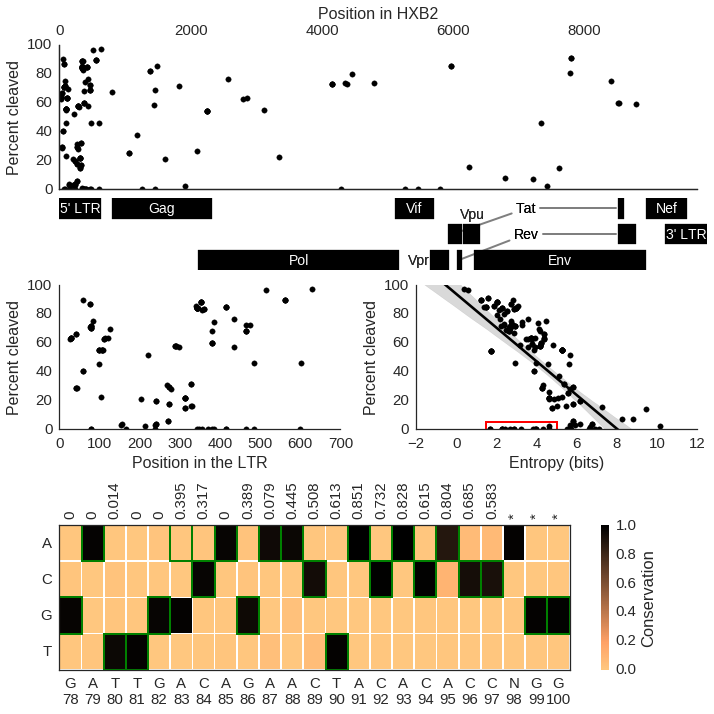

In [25]:
hxb2_ax = plt.subplot2grid((3,2), (0,0), colspan=2)

data.plot(ax=hxb2_ax, x = 'Start', y = 'Percent cleaved', 
          kind='scatter', color = 'k', s = 30)

hxb2_ax.set_xlim(0, 9717)
hxb2_ax.set_xlabel('')
hxb2_ax.set_xticks([])
hxb2_ax.set_ylim(0, 100)
hxb2_ax.set_ylabel('Percent cleaved', fontsize=16)

tw_ax = hxb2_ax.twiny()
tw_ax.set_xlim(0, 9717)
tw_ax.set_xlabel('Position in HXB2', fontsize=16)
sbn.despine(ax=tw_ax, top=False)
tw_ax.spines['top'].set_visible(False)

sbn.despine(ax=hxb2_ax)

ltr_ax = plt.subplot2grid((3,2), (1,0))
data.plot(ax=ltr_ax, x = 'Start', y = 'Percent cleaved', 
          kind='scatter', color = 'k', s = 30)
ltr_ax.set_xlim(0, 700)
ltr_ax.set_ylim(0, 100)
ltr_ax.set_xlabel('Position in the LTR', fontsize=16)
ltr_ax.set_ylabel('Percent cleaved', fontsize=16)
sbn.despine(ax=ltr_ax)

ent_ax = plt.subplot2grid((3,2), (1,1))

data.plot(ax=ent_ax, x = 'Entropy (bits)', y = 'Percent cleaved', 
          kind='scatter', color = 'k', s = 30)
sbn.regplot(data = data, x = 'Entropy (bits)', 
            y = 'Percent cleaved', 
            ax=ent_ax, color = 'k')

ent_ax.set_xlabel('Entropy (bits)', fontsize=16)
ent_ax.set_ylabel('Percent cleaved', fontsize=16)
ent_ax.set_ylim(0, 100)
ent_ax.bar(left = 1.5, width = 3.5,
           bottom = -1, height = 6, linewidth = 2,
           edgecolor='r', facecolor='None')

sbn.despine(ax=ent_ax)

heat_ax = plt.subplot2grid((3,2), (2,0), colspan=2)
sbn.heatmap(res, ax=heat_ax, 
            vmin = 0, vmax = 1.0,
            cbar_kws={'label': 'Conservation'}, cmap='copper_r', linewidth=0.75)
gRNA = 'GATTGACAGAACTACACACCNGG'
heat_ax.set_xticklabels(['%s\n%i' % (l, p) for p, l in enumerate(gRNA, 78)], rotation=0)

for n, l in enumerate(gRNA):
    
    bottom = (a for a, b in enumerate('TGCA.N') if b == l).next()
    
    heat_ax.bar(left = n,
           width = 1,
           height = 1,
           bottom = bottom,
           linewidth = 2,
           edgecolor = 'g', 
           facecolor='None')
[t.set_rotation(0) for t in heat_ax.get_yticklabels()]
    
    
pen_ax = heat_ax.twiny()
pen_ax.set_xlim(0, 23)
pen_ax.set_xticks(np.arange(23)+0.5)
penalties = [0, 0, 0.014, 0, 0, 0.395, 0.317, 0,
                 0.389, 0.079, 0.445, 0.508, 0.613,
                 0.851, 0.732, 0.828, 0.615, 0.804,
                 0.685, 0.583]
pen_ax.set_xticklabels(penalties+list('***'), rotation = 90)

fig = plt.gcf()
fig.set_figheight(10)
fig.set_figwidth(10)
fig.tight_layout()

ax = fig.add_axes([0.0875, 0.62, .90, 0.1])
ax.set_yticks([])
ax.set_xticks([])

points = [("5' LTR", 1, 634, 1),
          ("Gag", 790, 2292, 1),
          ("Pol", 2085, 5096, 3),
          ("Vif", 5041, 5619, 1),
          ("Vpr", 5559, 5850, 3),
          ("Tat1", 5831, 6045, 2),
          ("Tat2", 8379, 8469, 1), 
          ("Rev1", 5970, 6045, 3), 
          ("Rev2", 8379, 8653, 2),
          ("Vpu", 6062, 6310, 2), 
          ("Env", 6225, 8795, 3), 
          ("Nef", 8797, 9417, 1), 
          ("3' LTR", 9086,  9719, 2)]

for name, start, stop, frame in points:
    
    ax.bar(bottom = frame+0.1, height = 0.8,
           left = start, width = stop-start,
           edgecolor = 'k', facecolor='k')
    if stop-start > 500:
        ax.annotate(name, xy = (start + (stop-start)/2, frame+0.5, ),
                    ha = 'center', va='center', color='w', fontsize=14)

a = 0.5
        
ax.annotate("Tat", xy = (5900, 2.5), xycoords = 'data', xytext = (7000, 1.5),
            fontsize=14, color='k',ha = 'center', va='center',
            arrowprops=dict(arrowstyle="-",
                            connectionstyle="arc",
                            lw=2, alpha=a
                            ))
ax.annotate("Tat", xy = (8379, 1.5), xycoords = 'data', xytext = (7000, 1.5),
            fontsize=14, color='k',ha = 'center', va='center',
            arrowprops=dict(arrowstyle="-",
                            connectionstyle="arc",
                            lw=2, alpha=a
                            ))

ax.annotate("Rev", xy = (6000, 3.5), xycoords = 'data', xytext = (7000, 2.5),
            fontsize=14, color='k',ha = 'center', va='center',
            arrowprops=dict(arrowstyle="-",
                            connectionstyle="arc",
                            lw=2, alpha=a
                            ))
ax.annotate("Rev", xy = (8379, 2.5), xycoords = 'data', xytext = (7000, 2.5),
            fontsize=14, color='k',ha = 'center', va='center',
            arrowprops=dict(arrowstyle="-",
                            connectionstyle="arc",
                            lw=2, alpha=a
                            ))


ax.annotate('Vpr', xy = (5559, 3.5), xycoords = 'data', fontsize=14,
            ha='right', va='center')
ax.annotate('Vpr', xy = (5559, 3.5), xycoords = 'data', fontsize=14,
            ha='right', va='center')

ax.annotate('Vpu', xy = (6200, 2), xycoords = 'data', fontsize=14,
            ha='center', va='bottom')
ax.annotate('Vpu', xy = (6200, 2), xycoords = 'data', fontsize=14,
            ha='center', va='bottom')

sbn.despine(ax=ax, left=True, bottom=True)    
    
ax.invert_yaxis()

fig.savefig('../papers/Sullivan-2017-NatBiotech/Fig1ABCD_alt.png', dpi=300)